In [2]:
import spacy
import keras
import numpy as np
import pandas as pd
from random import randint
from pickle import dump,load
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras import optimizers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, Embedding, Dense
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

I am using the spam dataset that youn can found in the repository.

In [4]:
#Import text file
text_file = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Word_Predicator/spam.csv', header=0 , names=["label", "text"])
text_file.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


I think it is better to use the text from Ham messages to use words and sentences from legit conversations.

In [5]:
#Filter the text to obtain only the ham text messages
new = text_file[text_file['label'] == "ham"]

#Create a big text file
text = ' '.join(text_file['text'])

# Prepare the data

In [6]:
#remove the punctuations
#Load spacy vocab
nlp = spacy.load('en', disable=['parser', 'tagger','ner'])

tokens = [token.text.lower() for token in nlp(text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n n ..']

In [7]:
#Previous words to take into account to make the prediction
train_len = 10+1 #10 previous words + 1 word to predict

#Empty list of training sequence
sequence_list = [] 

In [8]:
for i in range(train_len, len(tokens)):
    
    #Get the training sequence
    seq = tokens[i-train_len:i] 
    
    #Add it to the list
    sequence_list.append(seq) 

In [9]:
sequence_list[0]

['go',
 'until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'great',
 'world']

In [10]:
sequence_list[1]

['until',
 'jurong',
 'point',
 'crazy',
 'available',
 'only',
 'in',
 'bugis',
 'great',
 'world',
 'la']

In [11]:
#encode text sequence to numeric sequence
tokenize = Tokenizer()
tokenize.fit_on_texts(sequence_list)
num_sequence = tokenize.texts_to_sequences(sequence_list)

In [12]:
num_sequence[0]

[53, 468, 9506, 853, 804, 693, 70, 10, 1429, 122, 360]

In [14]:
len(tokenize.word_counts)

9506

In [15]:
len_vocab = len(tokenize.word_counts)
len_vocab

9506

In [16]:
num_sequence = np.array(num_sequence)
num_sequence[:5]

array([[  53,  468, 9506,  853,  804,  693,   70,   10, 1429,  122,  360],
       [ 468, 9506,  853,  804,  693,   70,   10, 1429,  122,  360, 1273],
       [9506,  853,  804,  693,   70,   10, 1429,  122,  360, 1273,  160],
       [ 853,  804,  693,   70,   10, 1429,  122,  360, 1273,  160, 2926],
       [ 804,  693,   70,   10, 1429,  122,  360, 1273,  160, 2926,    6]])

For a better performance, I will use the first 1000 examples.

In [17]:
# Divide independent and target data
X = num_sequence[:,:-1]
y = to_categorical(num_sequence[:,-1], num_classes=len_vocab+1)

In [18]:
len(y[0])

9507

In [19]:
X.shape, y.shape

((89673, 10), (89673, 9507))

In [20]:
# Split the data into train validation and test set
# 80 - 20 train - test split, and 70 - 30 train - validation split
Xtest , Ytest = X[:17935], y[:17935]
Xtrain , Ytrain = X[17935:68152], y[17935:68152]
Xvalid , Yvalid = X[68152:], y[68152:]

In [21]:
len(Xtest), len(Xtrain), len(Xvalid)

(17935, 50217, 21521)

In [22]:
seq_len = X.shape[1]
seq_len

10

# Build a recurrent neural network

In [ ]:
# Creating LSTM based model
model = Sequential()
model.add(Embedding(len_vocab+1, 10, input_length=seq_len))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(150))
model.add(Dense(150, activation='relu'))
model.add(Dense(len_vocab+1, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(0.01), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 10)            95070     
_________________________________________________________________
lstm (LSTM)                  (None, 10, 150)           96600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense (Dense)                (None, 150)               22650     
_________________________________________________________________
dense_1 (Dense)              (None, 9507)              1435557   
Total params: 1,830,477
Trainable params: 1,830,477
Non-trainable params: 0
_________________________________________________________________


# Train the model and tune the hyperparameters

In [ ]:
# fit model
history = model.fit(Xtrain, Ytrain, batch_size=128, epochs=50, validation_data=(Xvalid, Yvalid))

Epoch 1/50
5/5 [==============================] - 4s 195ms/step - loss: 9.0141 - accuracy: 0.0204 - val_loss: 7.2017 - val_accuracy: 0.0583
Epoch 2/50
5/5 [==============================] - 0s 31ms/step - loss: 6.2286 - accuracy: 0.0237 - val_loss: 7.4765 - val_accuracy: 0.0042
Epoch 3/50
5/5 [==============================] - 0s 29ms/step - loss: 5.8222 - accuracy: 0.0258 - val_loss: 8.3430 - val_accuracy: 0.0583
Epoch 4/50
5/5 [==============================] - 0s 29ms/step - loss: 5.5616 - accuracy: 0.0342 - val_loss: 8.4229 - val_accuracy: 0.0625
Epoch 5/50
5/5 [==============================] - 0s 27ms/step - loss: 5.5493 - accuracy: 0.0394 - val_loss: 8.5427 - val_accuracy: 0.0625
Epoch 6/50
5/5 [==============================] - 0s 28ms/step - loss: 5.4825 - accuracy: 0.0372 - val_loss: 8.2260 - val_accuracy: 0.0625
Epoch 7/50
5/5 [==============================] - 0s 27ms/step - loss: 5.4728 - accuracy: 0.0476 - val_loss: 8.4986 - val_accuracy: 0.0625
Epoch 8/50
5/5 [==========

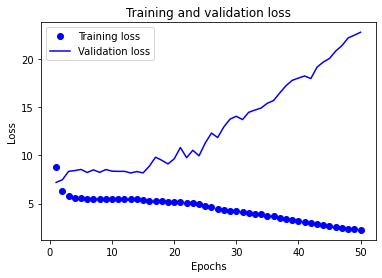

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs,loss, 'bo', label='Training loss') #blue dots
plt.plot(epochs,val_loss, 'b', label='Validation loss') #blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

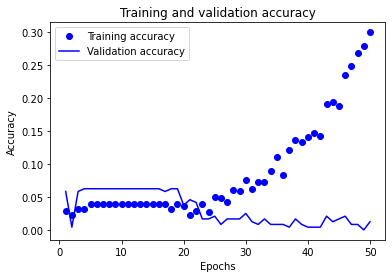

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs,acc, 'bo', label='Training accuracy') #blue dots
plt.plot(epochs,val_acc, 'b', label='Validation accuracy') #blue line
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that the model is not performant enough.